# IMPORTS

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Data

In [2]:
from novelty_detection.data import load_data
df = load_data("mgdata.txt", header_names=['t', 'x'])
print(df.shape)
df.head()

(1201, 2)


,t,x
0,0,1.200000
1,1,1.085805
2,2,0.982477
3,3,0.888982
4,4,0.804384


# PREPROCESSING

In [3]:
start, end = 118, 1118

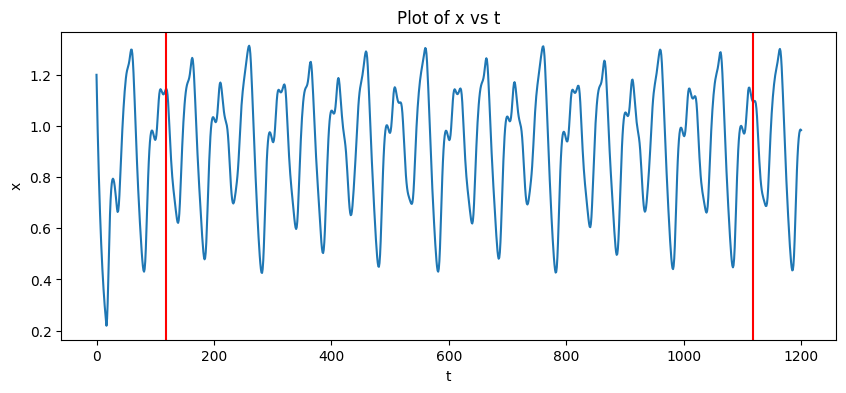

In [4]:
plt.figure(figsize=(10, 4))  # Wider figure size
plt.plot(df['t'], df['x'])
plt.axvline(x=start, color='red')
plt.axvline(x=end,color='red')
plt.title("Plot of x vs t")
plt.xlabel("t")
plt.ylabel("x")
plt.show()

In [5]:
list_of_dicts = []

# Iterate over the specified range of 't'
for t in range(start, end):
    # Extract 'x' values at specified offsets and store them in a dictionary
    dict_row = {
        't':t,
        'x(t-18)': df.loc[df['t'] == t - 18, 'x'].values[0],
        'x(t-12)': df.loc[df['t'] == t - 12, 'x'].values[0],
        'x(t-6)': df.loc[df['t'] == t - 6, 'x'].values[0],
        'x(t)': df.loc[df['t'] == t, 'x'].values[0],
        'x(t+6)': df.loc[df['t'] == t + 6, 'x'].values[0]
    }
    # Append the dictionary to the list
    list_of_dicts.append(dict_row)

# Convert the list of dictionaries to a DataFrame
data = pd.DataFrame(list_of_dicts, columns=list(list_of_dicts[0].keys()))

print(data.shape)
data.head()  # Displaying the first few rows of the new DataFrame for reference

(1000, 6)


,t,x(t-18),x(t-12),x(t-6),x(t),x(t+6)
0,118,0.945426,1.100331,1.129145,1.143128,1.004313
1,119,0.949830,1.125689,1.124705,1.144988,0.956414
2,120,0.964947,1.139706,1.123387,1.139072,0.910743
3,121,0.991405,1.143858,1.125572,1.121762,0.869387
4,122,1.026797,1.141285,1.130703,1.091658,0.833268


More general way to generate dataset

In [6]:
# Generate dataset
D = 4  # number of regressors == dim input data 
T = 6  # delay

# total of data points
N = end-start

In [7]:
list_of_lists = []

for t in range(start, end):
    X_row = [t]
    for d in reversed(range(1,D+1)):
        X_row.append(df.loc[df['t'] == t - (d - 1) * T, 'x'].values[0])
    # add target at the end of the list
    X_row.append(df.loc[df['t'] == t + T, 'x'].values[0])
    list_of_lists.append(X_row)

column_names = ['t']
for d in reversed(range(1,D+1)):
    col_name = f'x(t-{(d - 1) * T})'
    column_names.append(col_name)

column_names.append(f'x(t+{T})')

# Convert to DataFrame with specified column names
data2 = pd.DataFrame(list_of_lists, columns=column_names)
data2.head()  

,t,x(t-18),x(t-12),x(t-6),x(t-0),x(t+6)
0,118,0.945426,1.100331,1.129145,1.143128,1.004313
1,119,0.949830,1.125689,1.124705,1.144988,0.956414
2,120,0.964947,1.139706,1.123387,1.139072,0.910743
3,121,0.991405,1.143858,1.125572,1.121762,0.869387
4,122,1.026797,1.141285,1.130703,1.091658,0.833268


Faster and general way to generate the dataset

In [8]:
def split_sequence(sequence, n_steps, step_interval=1, start=0, end=None):
    X, y = list(), list()
    if end is None:
        end = len(sequence)

    # Adjust start index as before
    adjusted_start = start - (n_steps - 1) * step_interval
    if adjusted_start < 0:
        adjusted_start = 0

    for i in range(adjusted_start, end):
        # calculate the end index of the pattern in X
        end_ix = i + (n_steps - 1) * step_interval
        # calculate the index of the output value in y
        out_ix = end_ix + step_interval
        # calculate the index for x(t)
        x_t_index = i + (n_steps - 1) * step_interval
        # gather input and output parts of the pattern
        seq_x = [x_t_index] + [sequence[i + j * step_interval] for j in range(n_steps) if i + j * step_interval < len(sequence)]
        seq_y = sequence[out_ix] if out_ix < len(sequence) else None
        X.append(seq_x)
        y.append(seq_y)

        # Check if the current x(t) index has reached or exceeded the end index
        if x_t_index >= end - 1:
            break

    return X, y

X,y=split_sequence(list(df['x']), D, T, start, end)


In [9]:
column_names = ['t']
for d in reversed(range(1,D+1)):
    col_name = f'x(t-{(d - 1) * T})'
    column_names.append(col_name)

data3 = pd.DataFrame(X, columns=column_names)
data3[f'x(t+{T})'] = y
data3.head()

,t,x(t-18),x(t-12),x(t-6),x(t-0),x(t+6)
0,118,0.945426,1.100331,1.129145,1.143128,1.004313
1,119,0.949830,1.125689,1.124705,1.144988,0.956414
2,120,0.964947,1.139706,1.123387,1.139072,0.910743
3,121,0.991405,1.143858,1.125572,1.121762,0.869387
4,122,1.026797,1.141285,1.130703,1.091658,0.833268


## Split

In [10]:
thresh = 500

In [11]:
features = ['x(t-18)', 'x(t-12)', 'x(t-6)', 'x(t)']
targets = ['x(t+6)']
time = ['t']

trnData = data.loc[:thresh-1, features]
chkData = data.loc[thresh:, features]

trnLbls = data.loc[:thresh-1, targets]
chkLbls = data.loc[thresh:, targets]

trnTime = data.loc[:thresh-1, time]
chkTime = data.loc[thresh:, time]

print('training data shape: ', trnData.shape)
print('validation data shape: ', chkData.shape)

training data shape:  (500, 4)
validation data shape:  (500, 4)


# TRAINING using tensorflow implementation

In [12]:
from novelty_detection.anfis_tf import ANFIS

# Example of use
fis = ANFIS(n_inputs=4, n_rules=10, learning_rate=1e-4, mf='gbellmf',defuzz_method='linear', loss_fun='huber', init_method='uniform')
fis.compile(run_eagerly=True)

# For training
fis.fit(trnData, trnLbls, epochs=250, batch_size=32)

# For evaluation
val_loss = fis.evaluate(chkData, chkLbls)
print("Validation loss:", val_loss)




Epoch 1/250
16/16 [==============================] - 0s 17ms/step - loss: 4.0130
Epoch 2/250
16/16 [==============================] - 0s 17ms/step - loss: 3.0199
Epoch 3/250
16/16 [==============================] - 0s 16ms/step - loss: 2.2812
Epoch 4/250
16/16 [==============================] - 0s 16ms/step - loss: 1.6953
Epoch 5/250
16/16 [==============================] - 0s 17ms/step - loss: 1.2005
Epoch 6/250
16/16 [==============================] - 0s 17ms/step - loss: 0.8442
Epoch 7/250
16/16 [==============================] - 0s 17ms/step - loss: 0.5904
Epoch 8/250
16/16 [==============================] - 0s 17ms/step - loss: 0.4549
Epoch 9/250
16/16 [==============================] - 0s 16ms/step - loss: 0.3583
Epoch 10/250
16/16 [==============================] - 0s 19ms/step - loss: 0.3191
Epoch 11/250
16/16 [==============================] - 0s 19ms/step - loss: 0.2526
Epoch 12/250
16/16 [==============================] - 0s 17ms/step - loss: 0.2126
Epoch 13/250
16/16 [==

16/16 [==============================] - 0s 2ms/step


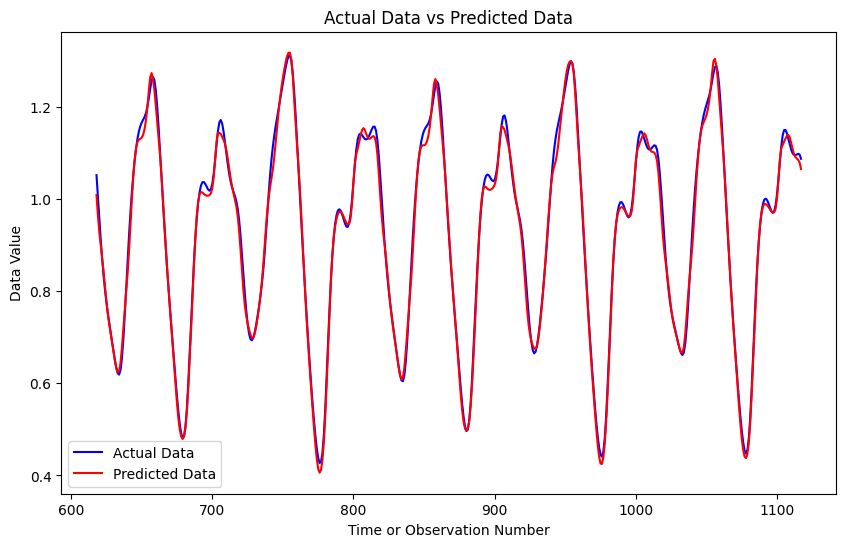

In [13]:
# Assuming fis is your ANFIS model and mg_series is your actual data
# Prepare your input data in the correct format (modify as necessary)

input_data = chkData.to_numpy() 

# Generate predictions
predicted_data = fis.predict(input_data)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(chkTime, chkLbls, label='Actual Data', color='blue')
plt.plot(chkTime, predicted_data, label='Predicted Data', color='red')
plt.title('Actual Data vs Predicted Data')
plt.xlabel('Time or Observation Number')
plt.ylabel('Data Value')
plt.legend()
plt.show()

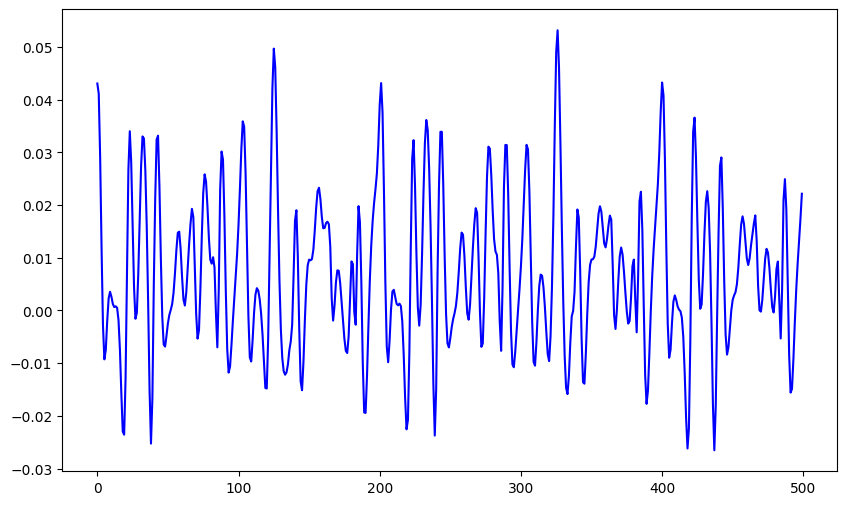

In [14]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(chkLbls.to_numpy().flatten()-predicted_data, label='Actual Data', color='blue')
plt.show()


In [15]:
print(sum(abs(chkLbls.to_numpy().flatten()-predicted_data.flatten())))

6.1911779217987055


# TRAINING using MLP

In [16]:
from keras.models import Sequential
from keras.layers import Dense

model_mlp=Sequential()
model_mlp.add(Dense(128,activation="relu",input_dim=trnData.shape[1]))
model_mlp.add(Dense(64,activation="relu"))
model_mlp.add(Dense(1,activation="selu"))
model_mlp.compile(loss='mse',optimizer="adam")

In [17]:
history_mlp=model_mlp.fit(trnData,trnLbls,
                          epochs=1000,
                          validation_data=(chkData,chkLbls), 
                          batch_size=64)

Epoch 1/1000

8/8 [==============================] - 1s 24ms/step - loss: 0.6499 - val_loss: 0.1745
Epoch 2/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0921 - val_loss: 0.0758
Epoch 3/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0929 - val_loss: 0.0838
Epoch 4/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.0633 - val_loss: 0.0448
Epoch 5/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0447 - val_loss: 0.0437
Epoch 6/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0405 - val_loss: 0.0360
Epoch 7/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0349 - val_loss: 0.0331
Epoch 8/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0310 - val_loss: 0.0284
Epoch 9/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0275 - val_loss: 0.0254
Epoch 10/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.0241 - val_loss: 0.0224
Epoch 11/1000
8/8

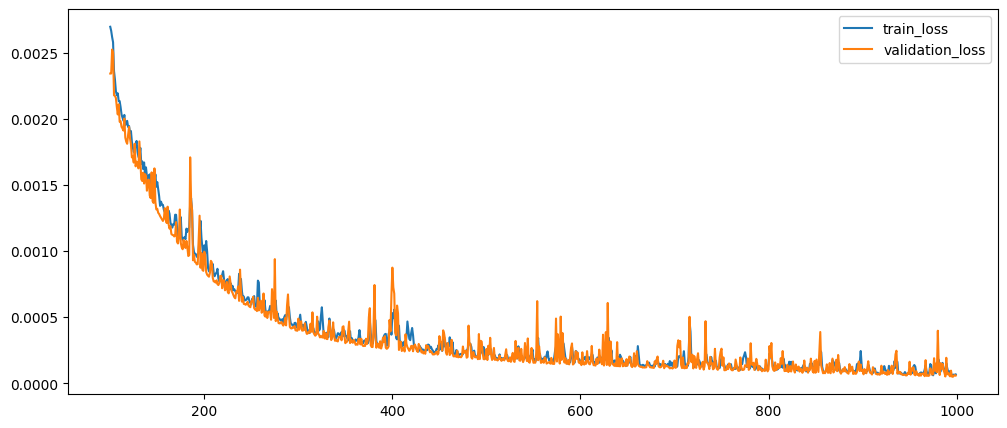

In [27]:
train_loss=history_mlp.history['loss']
val_loss=history_mlp.history['val_loss']
x = 100  
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(range(x, len(train_loss)), train_loss[x:], label='train_loss')
ax.plot(range(x, len(val_loss)), val_loss[x:], label='validation_loss')
ax.legend()
plt.show()

16/16 [==============================] - 0s 1ms/step


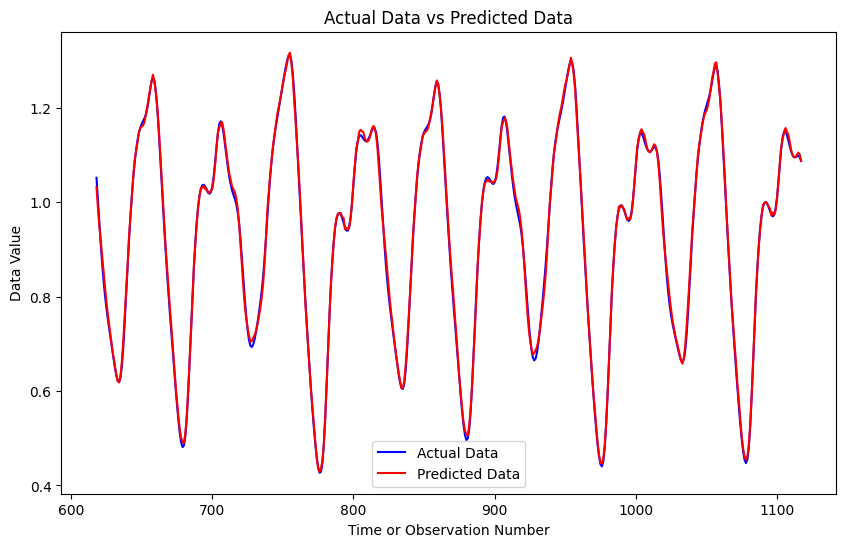

In [19]:
predict_mlp=model_mlp.predict(chkData)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(chkTime, chkLbls, label='Actual Data', color='blue')
plt.plot(chkTime, predict_mlp, label='Predicted Data', color='red')
plt.title('Actual Data vs Predicted Data')
plt.xlabel('Time or Observation Number')
plt.ylabel('Data Value')
plt.legend()
plt.show()

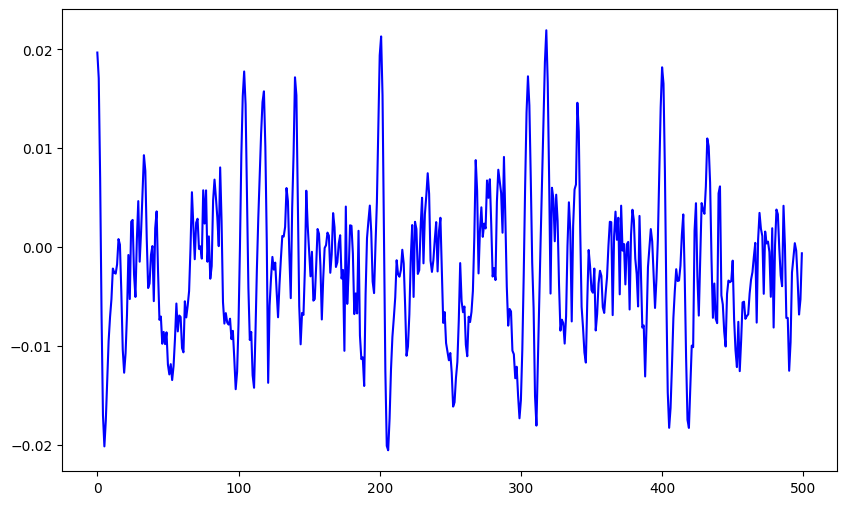

In [20]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(chkLbls.to_numpy().flatten()-predict_mlp.flatten(), label='Actual Data', color='blue')
plt.show()

In [21]:
print(sum(abs(chkLbls.to_numpy().flatten()-predict_mlp.flatten())))

3.0134416373748754


# MATLAB results

(1000, 3)


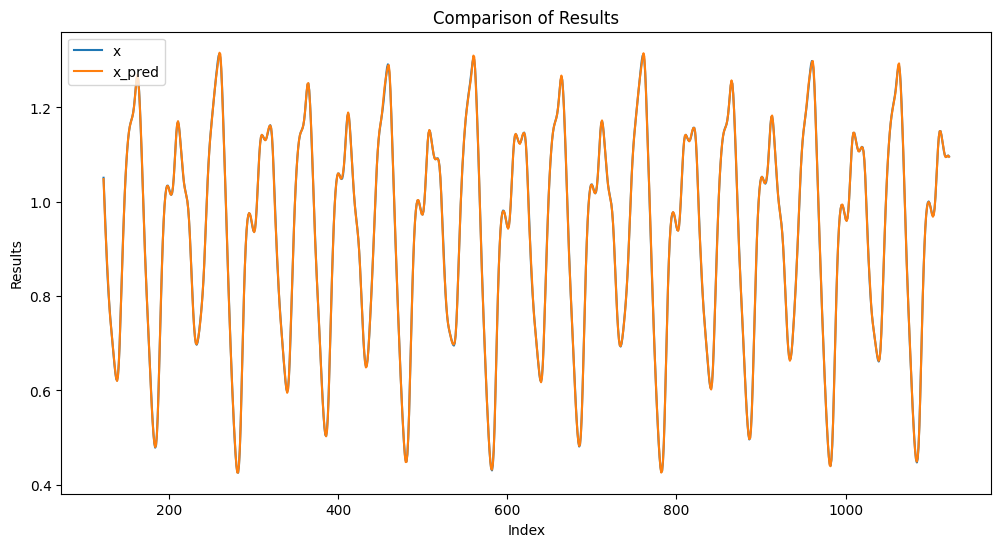

In [28]:
df = load_data("mgresults.txt", header_names=['t', 'x', 'x_pred'])
print(df.shape)
df.head()

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['t'], df['x'], label='x')
ax.plot(df['t'], df['x_pred'], label='x_pred')
ax.set_xlabel('Index')
ax.set_ylabel('Results')
ax.set_title('Comparison of Results')
ax.legend()
plt.show()